In [11]:
import pandas as pd

# For some reason, NKX2-2 files have some complex dedup counts greater than simple

In [24]:
simple_counts = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2/SK_pipeline/no_err_corr/trebl_experiment_a23_ADBC_Rim_Puro_R3_T0_S165/a23_ADBC_Rim_Puro_R3_T0_S165_simple_umi_counts.tsv", sep = "\t")
simple_counts["gene"] = simple_counts["ADBC2"] + simple_counts["HawkBCs"]
simple_counts

,ADBC2,HawkBCs,count,gene
0,CCATAA,CACCGATTG,122174,CCATAACACCGATTG
1,ATGATC,CAATCTCTC,56212,ATGATCCAATCTCTC
2,TTAGGC,CAACAGTGC,50339,TTAGGCCAACAGTGC
3,GCCTGT,CACAACTTC,47420,GCCTGTCACAACTTC
4,GAGTTT,CAACGCTTC,44210,GAGTTTCAACGCTTC
...,...,...,...,...
22586,GAACTC,CACACCAAC,1,GAACTCCACACCAAC
22587,TTCTGT,CATACGATC,1,TTCTGTCATACGATC
22588,GAGAGA,CACTATACA,1,GAGAGACACTATACA
22589,GTTATA,ACGCCCGAA,1,GTTATAACGCCCGAA


In [25]:
complex_counts = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2/SK_pipeline/no_err_corr/trebl_experiment_a23_ADBC_Rim_Puro_R3_T0_S165/a23_ADBC_Rim_Puro_R3_T0_S165_directional_umi_counts.tsv", sep = "\t")
complex_counts

,gene,count
0,CACTGCCATCCACTA,7833
1,CCAGGACACCGATTG,15459
2,TAAATAAGAGAGAAC,13751
3,ACATTTACCGAGCTT,3981
4,GCGGCACATCCACTA,25932
...,...,...
22561,CACTCAATCCGCTGT,1
22562,AGACAGCAAAAATTC,1
22563,TCGATGCCACCTTAC,1
22564,GTACAAACAAGCGGA,1


In [26]:
count_comparison = pd.merge(simple_counts[["gene", "count"]], complex_counts, on = 'gene', suffixes =("_simple", "_complex"))
count_comparison["diff"] = count_comparison["count_simple"] - count_comparison["count_complex"]
count_comparison[count_comparison["diff"] < 0]

,gene,count_simple,count_complex,diff
1024,AGCAGGCATCGGCGT,15,16,-1
1356,TAAATAAGAGGGAAC,10,11,-1
5059,ATGATCCAATATCTC,2,3,-1
5668,TGAGACAACCCCTTC,2,3,-1
6147,TCTTGTCCATTGGTT,2,3,-1
6358,GTACAACCATGGGTT,2,3,-1
6667,ACGTAGCAGGCCTTG,2,3,-1
7711,AACCATCAATCGCGG,2,3,-1
10029,AAAGGAAGGTGGCTC,1,2,-1
10765,TAAGTACATCATGTC,1,2,-1


# I think it's because bowtie2 parameters were too permissive, now made stricter.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from concurrent.futures import ThreadPoolExecutor, as_completed
import dask.dataframe as dd
import sys
import glob
import os

sys.path.append("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/")
from scripts import initial_map, map_refiner, complexity, finder, preprocess, error_correct, plotting, umi_deduplicate, pipelines


from tqdm import tqdm  # progress bar

In [4]:
pipeline_no_err_corr = pipelines.TreblPipeline(db_path = "../../duckdb/NKX2-2_pipeline_test_no_err_corr.db",
                        design_file_path = "../../data/DNA_Tiles_nkx2_2.txt",
                        error_correction = False,
                        output_path = "../../output/NKX2-2/pipeline_test/no_err_corr")


In [5]:
AD_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/TL4_results/data/RNA/a*")
RT_seq_files = glob.glob("/global/scratch/projects/fc_mvslab/OpenProjects/Caitlin/L4/TL4_results/data/RNA/r*")
trebl_exp_ADBC2 = finder.Barcode(name = "ADBC2",
                       preceder = "TATGCTAT",
                       post = "GGCCGGCCG",
                       length = 6)

trebl_exp_HawkBCs = finder.Barcode(name = "HawkBCs",
                       preceder = "TAGC",
                       post = "CTCGAGA",
                       length = 9)
trebl_exp_RTBC = finder.Barcode(name = "RTBC",
                       preceder = "GCCCC",
                       post = "GCGG",
                       length = 16)

UMI = finder.Barcode(name = "UMI", preceder = "", post = "", length = 12)

✓ Initial map already exists: trebl_experiment_a2_RNA_ADBC_S18_ADBC2_HawkBCs_initial — skipping
Base prefix (stable across descriptors): trebl_experiment_a2_RNA_ADBC_S18_ADBC2_HawkBCs_
Full prefix for this instance: trebl_experiment_a2_RNA_ADBC_S18_ADBC2_HawkBCs_

Using the following step order:
1. initial
2. quality


Filtering to high-quality reads...
Created table: trebl_experiment_a2_RNA_ADBC_S18_ADBC2_HawkBCs_quality — filtered for TRUE in all *_qual columns.
Done in 0.77 seconds.

Done.
Saved loss summary table as 'trebl_experiment_a2_RNA_ADBC_S18_ADBC2_HawkBCs_loss_summary'
Done in 0.02 seconds.

Starting simple deduplication.
Finished simple deduplication.

Starting UMI Tools directional deduplication.
Generating FASTQ with UMIs in header and barcodes as sequence...
Writing FASTQ to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_umi_extracted.fastq (768018 reads)...


Writing FASTQ: 100%|██████████| 768018/768018 [00:00<00:00, 1810049.12it/s]


FASTQ complete: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_umi_extracted.fastq
Done in 0.95 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_a2_RNA_ADBC_S18_ADBC2_HawkBCs_unique_barcodes
Writing FASTA to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_barcodes_index


Building a SMALL index
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_barcodes_index.3.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_barcodes_index.3.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_barcodes_index.4.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_barcodes_index.4.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_barcodes_index.1.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_barcodes_index.1.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_barcodes_index.2.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_barcod

Done in 2.13 seconds.

Aligning .FASTQ to reference .FA ...


768018 reads; of these:
  768018 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    768018 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_umi_extracted.sorted.bam -S ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a2_RNA_ADBC_S18/a2_RNA_ADBC_S18_umi_deduplicated.bam
# job started at Thu Jan 22 12:08:03 2026 on n0092.savio2 -- e0681bed-eda8-4a4e-9f6c-9291150d2320
# pid: 934529, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None
# gene_tag                    

Writing FASTQ: 100%|██████████| 548282/548282 [00:00<00:00, 1783262.46it/s]


FASTQ complete: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_umi_extracted.fastq
Done in 0.67 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_a7_RNA_ADBC_S23_ADBC2_HawkBCs_unique_barcodes
Writing FASTA to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_barcodes_index


Building a SMALL index
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_barcodes_index.3.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_barcodes_index.3.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_barcodes_index.4.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_barcodes_index.4.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_barcodes_index.1.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_barcodes_index.1.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_barcodes_index.2.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_barcod

Done in 2.16 seconds.

Aligning .FASTQ to reference .FA ...


548282 reads; of these:
  548282 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    548282 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_umi_extracted.sorted.bam -S ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a7_RNA_ADBC_S23/a7_RNA_ADBC_S23_umi_deduplicated.bam
# job started at Thu Jan 22 12:09:09 2026 on n0092.savio2 -- d4528e72-ff9f-4c70-a9b2-c636ec5e77a0
# pid: 934723, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None
# gene_tag                    

Writing FASTQ: 100%|██████████| 659600/659600 [00:00<00:00, 1774988.61it/s]


FASTQ complete: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_umi_extracted.fastq
Done in 0.81 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_a1_RNA_ADBC_S17_ADBC2_HawkBCs_unique_barcodes
Writing FASTA to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_barcodes_index


Building a SMALL index
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_barcodes_index.3.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_barcodes_index.3.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_barcodes_index.4.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_barcodes_index.4.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_barcodes_index.1.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_barcodes_index.1.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_barcodes_index.2.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_barcod

Done in 1.24 seconds.

Aligning .FASTQ to reference .FA ...


659600 reads; of these:
  659600 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    659600 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_umi_extracted.sorted.bam -S ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_umi_deduplicated.bam
# job started at Thu Jan 22 12:09:54 2026 on n0092.savio2 -- 95fbc722-c5c2-4c14-ad48-fd90ffd6e784
# pid: 934916, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None
# gene_tag                    

Writing FASTQ: 100%|██████████| 678896/678896 [00:00<00:00, 1821708.53it/s]


FASTQ complete: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_umi_extracted.fastq
Done in 0.91 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_a3_RNA_ADBC_S19_ADBC2_HawkBCs_unique_barcodes
Writing FASTA to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_barcodes_index


Building a SMALL index
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_barcodes_index.3.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_barcodes_index.3.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_barcodes_index.4.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_barcodes_index.4.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_barcodes_index.1.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_barcodes_index.1.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_barcodes_index.2.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_barcod

Done in 1.50 seconds.

Aligning .FASTQ to reference .FA ...


678896 reads; of these:
  678896 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    678896 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_umi_extracted.sorted.bam -S ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a3_RNA_ADBC_S19/a3_RNA_ADBC_S19_umi_deduplicated.bam
# job started at Thu Jan 22 12:10:50 2026 on n0092.savio2 -- e821ffa5-a323-46a2-aebd-7244603f9b1d
# pid: 935124, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None
# gene_tag                    

Writing FASTQ: 100%|██████████| 602687/602687 [00:00<00:00, 1709967.97it/s]


FASTQ complete: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_umi_extracted.fastq
Done in 0.76 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_a6_RNA_ADBC_S22_ADBC2_HawkBCs_unique_barcodes
Writing FASTA to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_barcodes_index


Building a SMALL index
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_barcodes_index.3.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_barcodes_index.3.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_barcodes_index.4.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_barcodes_index.4.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_barcodes_index.1.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_barcodes_index.1.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_barcodes_index.2.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_barcod

Done in 1.47 seconds.

Aligning .FASTQ to reference .FA ...


602687 reads; of these:
  602687 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    602687 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_umi_extracted.sorted.bam -S ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a6_RNA_ADBC_S22/a6_RNA_ADBC_S22_umi_deduplicated.bam
# job started at Thu Jan 22 12:11:46 2026 on n0092.savio2 -- c854fa2e-c157-4592-81f0-9584979788e6
# pid: 935315, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None
# gene_tag                    

Writing FASTQ: 100%|██████████| 622642/622642 [00:00<00:00, 1797485.04it/s]


FASTQ complete: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_umi_extracted.fastq
Done in 0.76 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_a4_RNA_ADBC_S20_ADBC2_HawkBCs_unique_barcodes
Writing FASTA to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_barcodes_index


Building a SMALL index
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_barcodes_index.3.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_barcodes_index.3.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_barcodes_index.4.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_barcodes_index.4.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_barcodes_index.1.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_barcodes_index.1.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_barcodes_index.2.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_barcod

Done in 1.40 seconds.

Aligning .FASTQ to reference .FA ...


622642 reads; of these:
  622642 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    622642 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_umi_extracted.sorted.bam -S ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a4_RNA_ADBC_S20/a4_RNA_ADBC_S20_umi_deduplicated.bam
# job started at Thu Jan 22 12:12:36 2026 on n0092.savio2 -- 4fd3cf70-8346-4e91-9d69-b18d9b41b215
# pid: 935509, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None
# gene_tag                    

Writing FASTQ: 100%|██████████| 678671/678671 [00:00<00:00, 1806144.58it/s]


FASTQ complete: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_umi_extracted.fastq
Done in 0.83 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_a8_RNA_ADBC_S24_ADBC2_HawkBCs_unique_barcodes
Writing FASTA to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_barcodes_index


Building a SMALL index
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_barcodes_index.3.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_barcodes_index.3.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_barcodes_index.4.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_barcodes_index.4.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_barcodes_index.1.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_barcodes_index.1.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_barcodes_index.2.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_barcod

Done in 1.38 seconds.

Aligning .FASTQ to reference .FA ...


678671 reads; of these:
  678671 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    678671 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_umi_extracted.sorted.bam -S ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a8_RNA_ADBC_S24/a8_RNA_ADBC_S24_umi_deduplicated.bam
# job started at Thu Jan 22 12:13:24 2026 on n0092.savio2 -- e1e3f76c-e4fd-4552-8840-aef1a3c38eb8
# pid: 935702, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None
# gene_tag                    

Writing FASTQ: 100%|██████████| 701546/701546 [00:00<00:00, 1828334.14it/s]


FASTQ complete: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_umi_extracted.fastq
Done in 0.89 seconds.

Saving unique barcode(s) as reference file...
Creating table of unique concatenated barcodes: trebl_experiment_a5_RNA_ADBC_S21_ADBC2_HawkBCs_unique_barcodes
Writing FASTA to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_barcodes.fa...
Indexing FASTA with bowtie2-build, prefix: ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_barcodes_index


Building a SMALL index
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_barcodes_index.3.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_barcodes_index.3.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_barcodes_index.4.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_barcodes_index.4.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_barcodes_index.1.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_barcodes_index.1.bt2
Renaming ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_barcodes_index.2.bt2.tmp to ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_barcod

Done in 1.82 seconds.

Aligning .FASTQ to reference .FA ...


701546 reads; of these:
  701546 (100.00%) were unpaired; of these:
    0 (0.00%) aligned 0 times
    701546 (100.00%) aligned exactly 1 time
    0 (0.00%) aligned >1 times
100.00% overall alignment rate


Converting SAM -> BAM ...
Sorting BAM ...


[bam_sort_core] merging from 0 files and 32 in-memory blocks...


Indexing BAM ...
Deduplicating UMIs ...
# UMI-tools version: 1.1.6
# output generated by dedup -I ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_umi_extracted.sorted.bam -S ../../output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a5_RNA_ADBC_S21/a5_RNA_ADBC_S21_umi_deduplicated.bam
# job started at Thu Jan 22 12:14:19 2026 on n0092.savio2 -- 66c8b510-d12e-465f-bbce-19c4489294ff
# pid: 935895, system: Linux 4.18.0-553.34.1.el8_10.x86_64 #1 SMP Wed Jan 8 14:44:18 UTC 2025 x86_64
# assigned_tag                            : None
# cell_tag                                : None
# cell_tag_delim                          : None
# cell_tag_split                          : -
# chimeric_pairs                          : use
# chrom                                   : None
# compresslevel                           : 6
# detection_method                        : None
# filter_umi                              : None
# gene_tag                    

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.86 seconds.

Reverse complement of sequences...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Done in 2.59 seconds.

Extracting 1 barcodes...
RTBC: extracting between 'GCCCC' and 'GCGG'
Done in 0.61 seconds.

Extracting UMI...
UMI: extracting last 12 bases
Done in 0.57 seconds.



RuntimeError: Query interrupted

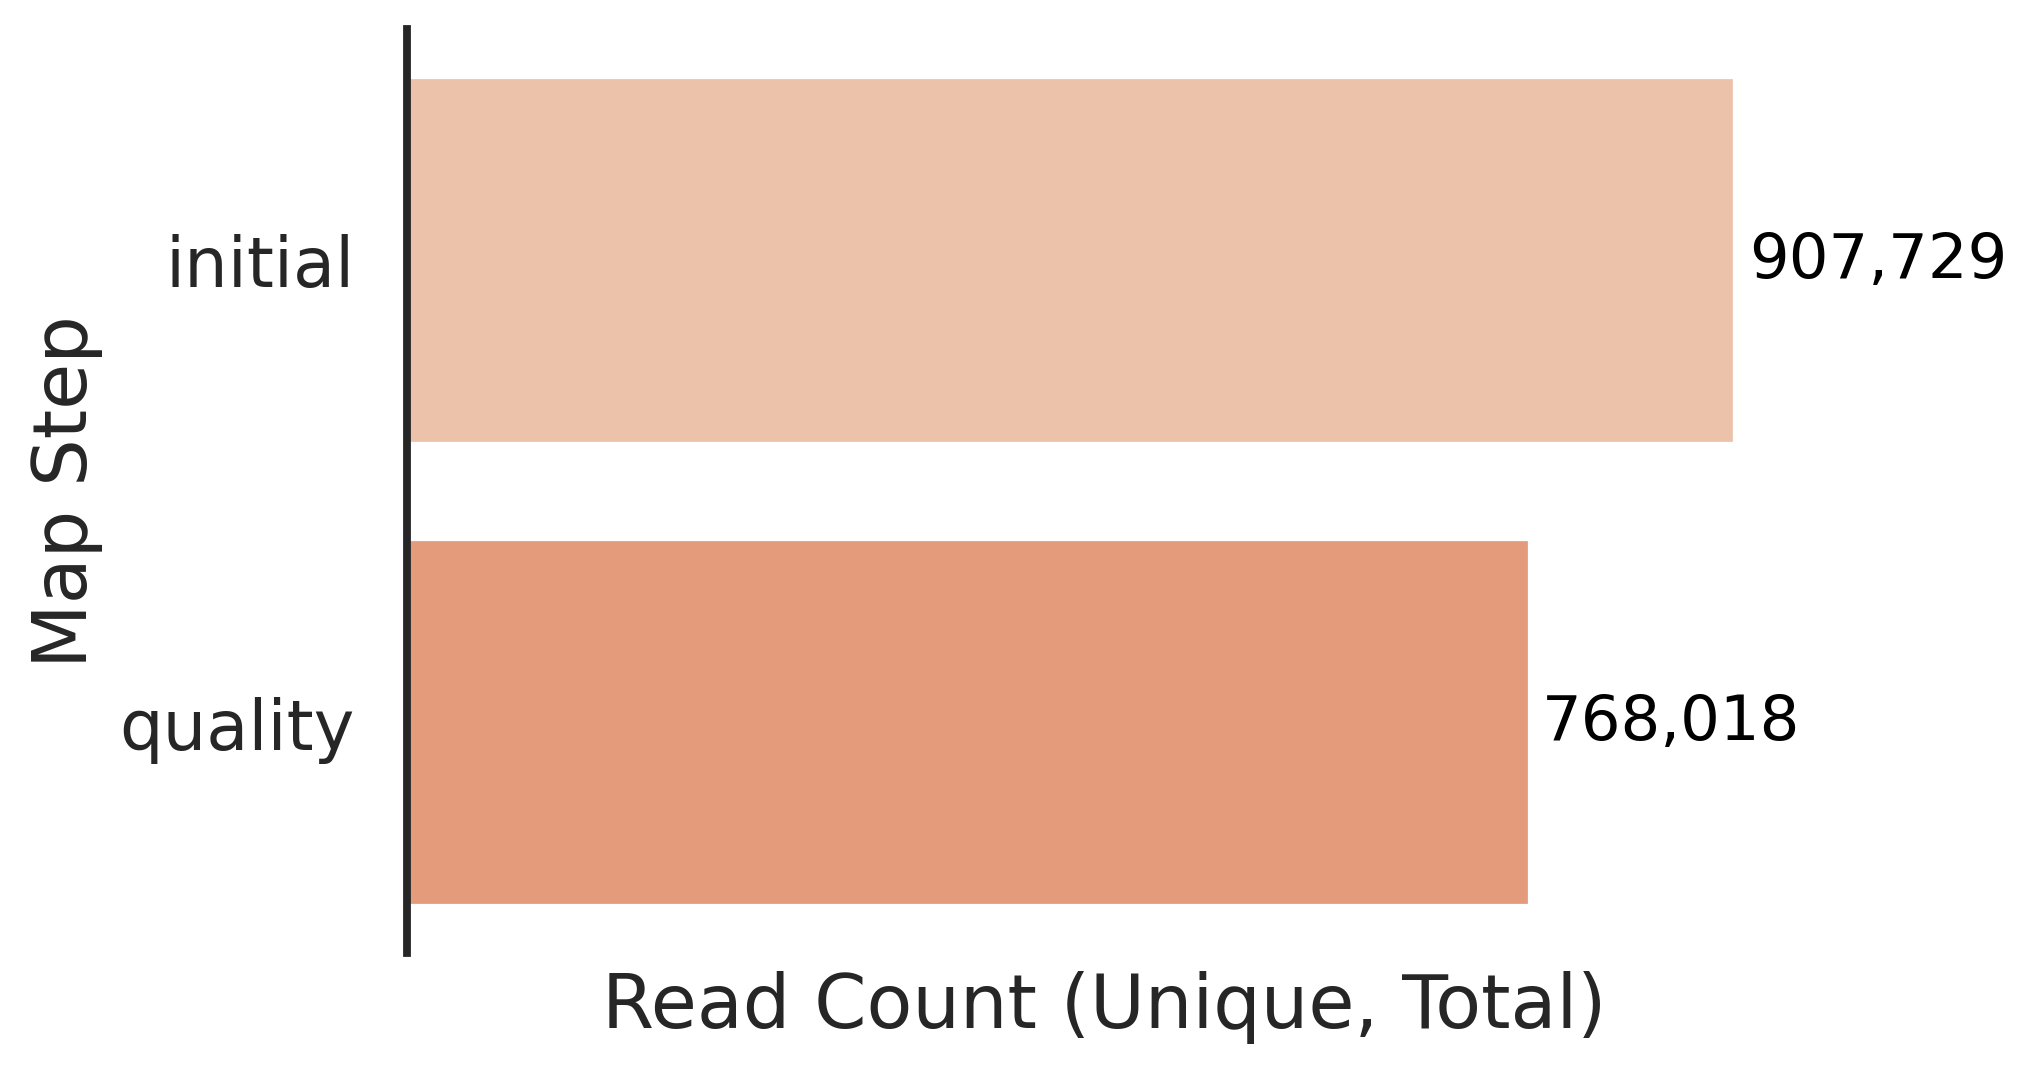

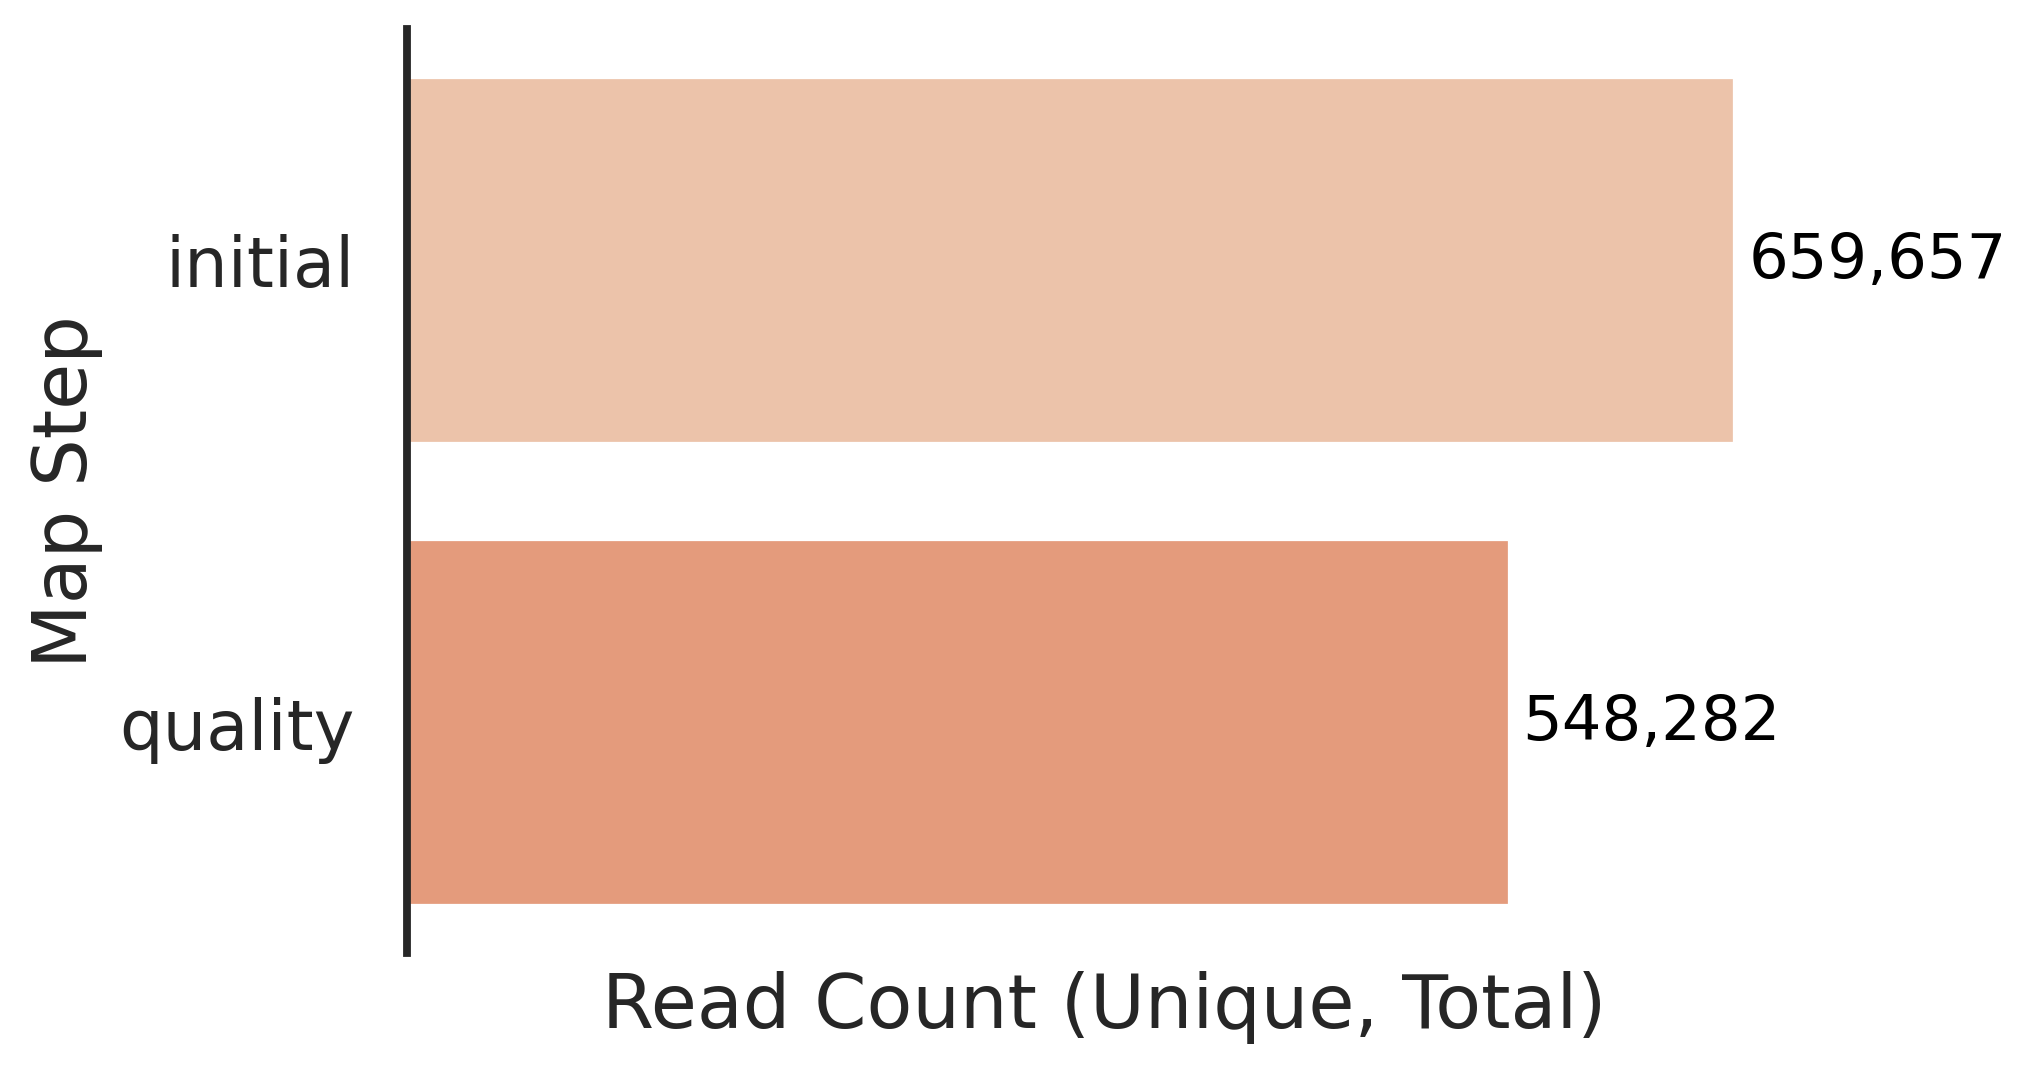

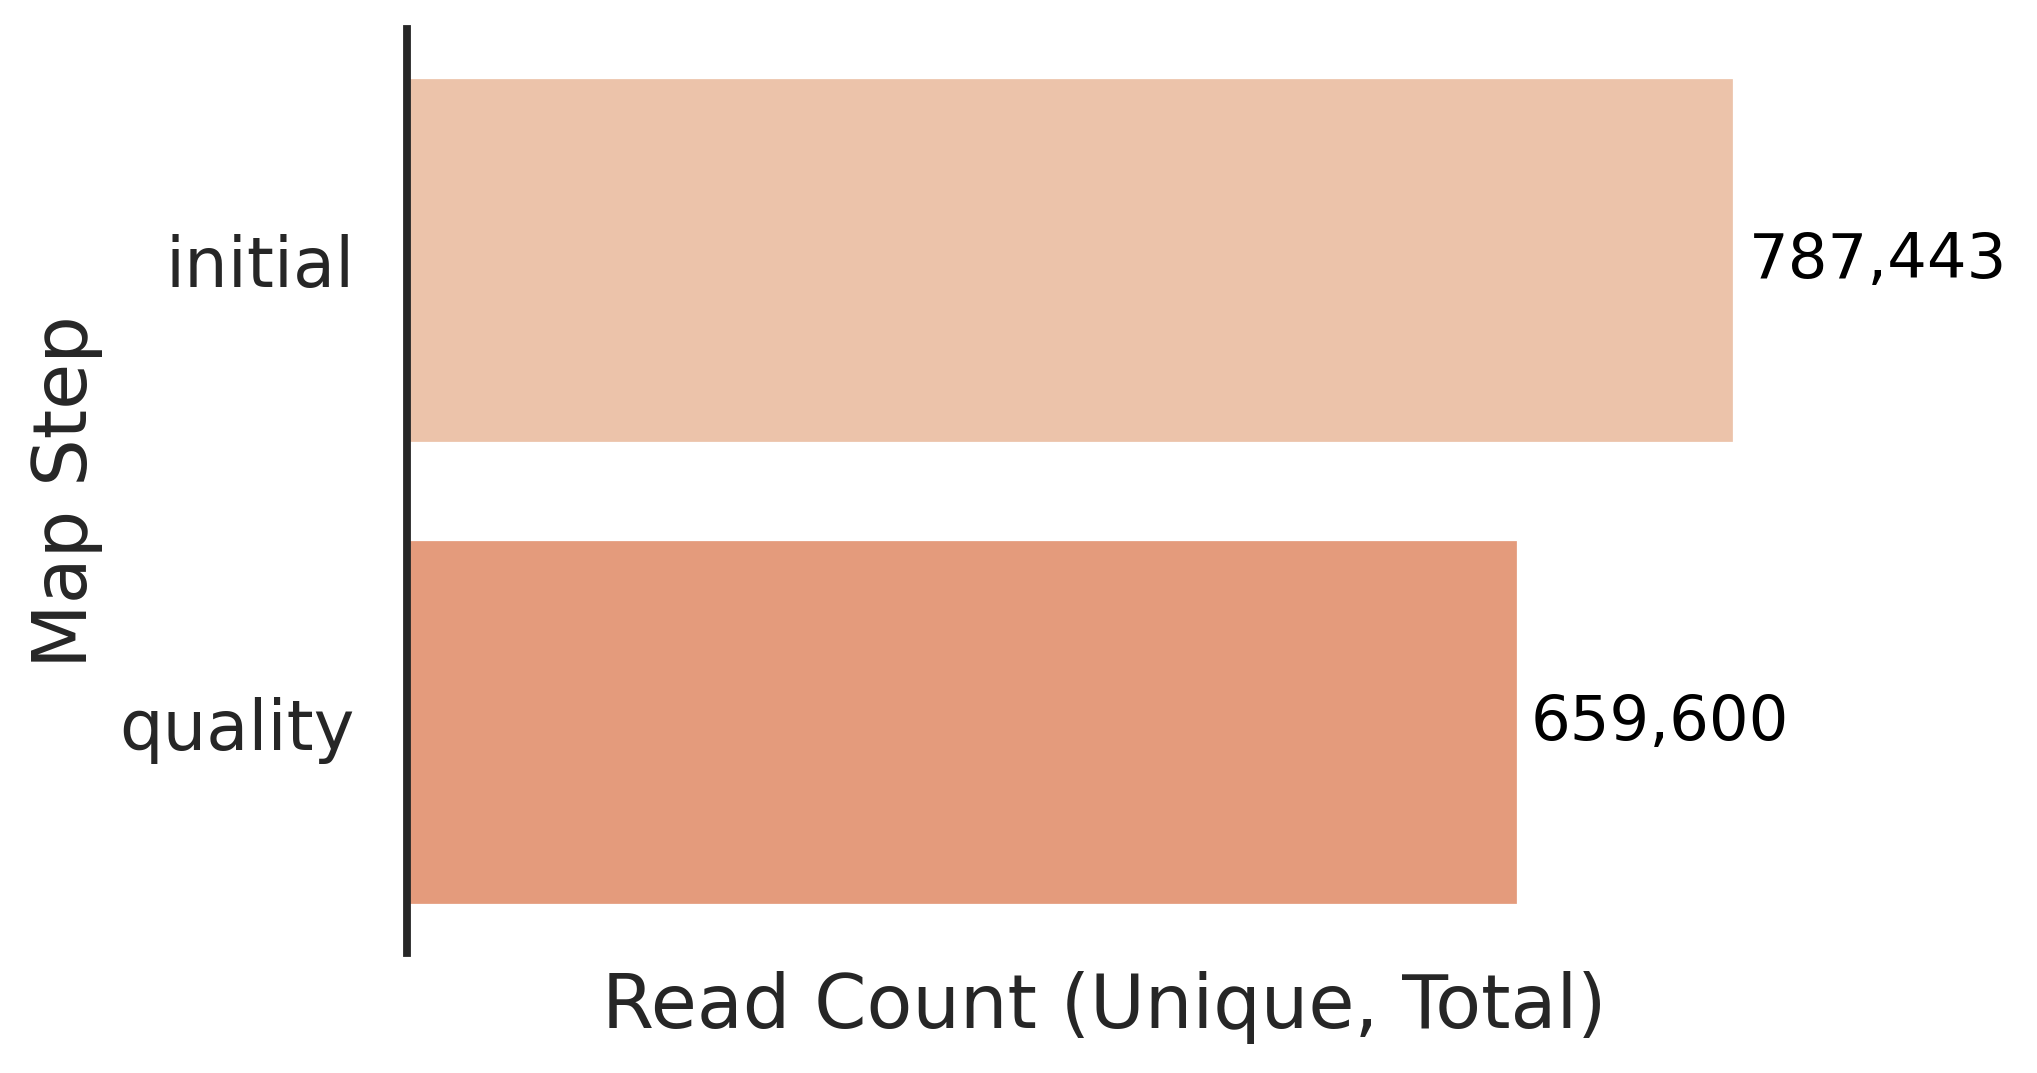

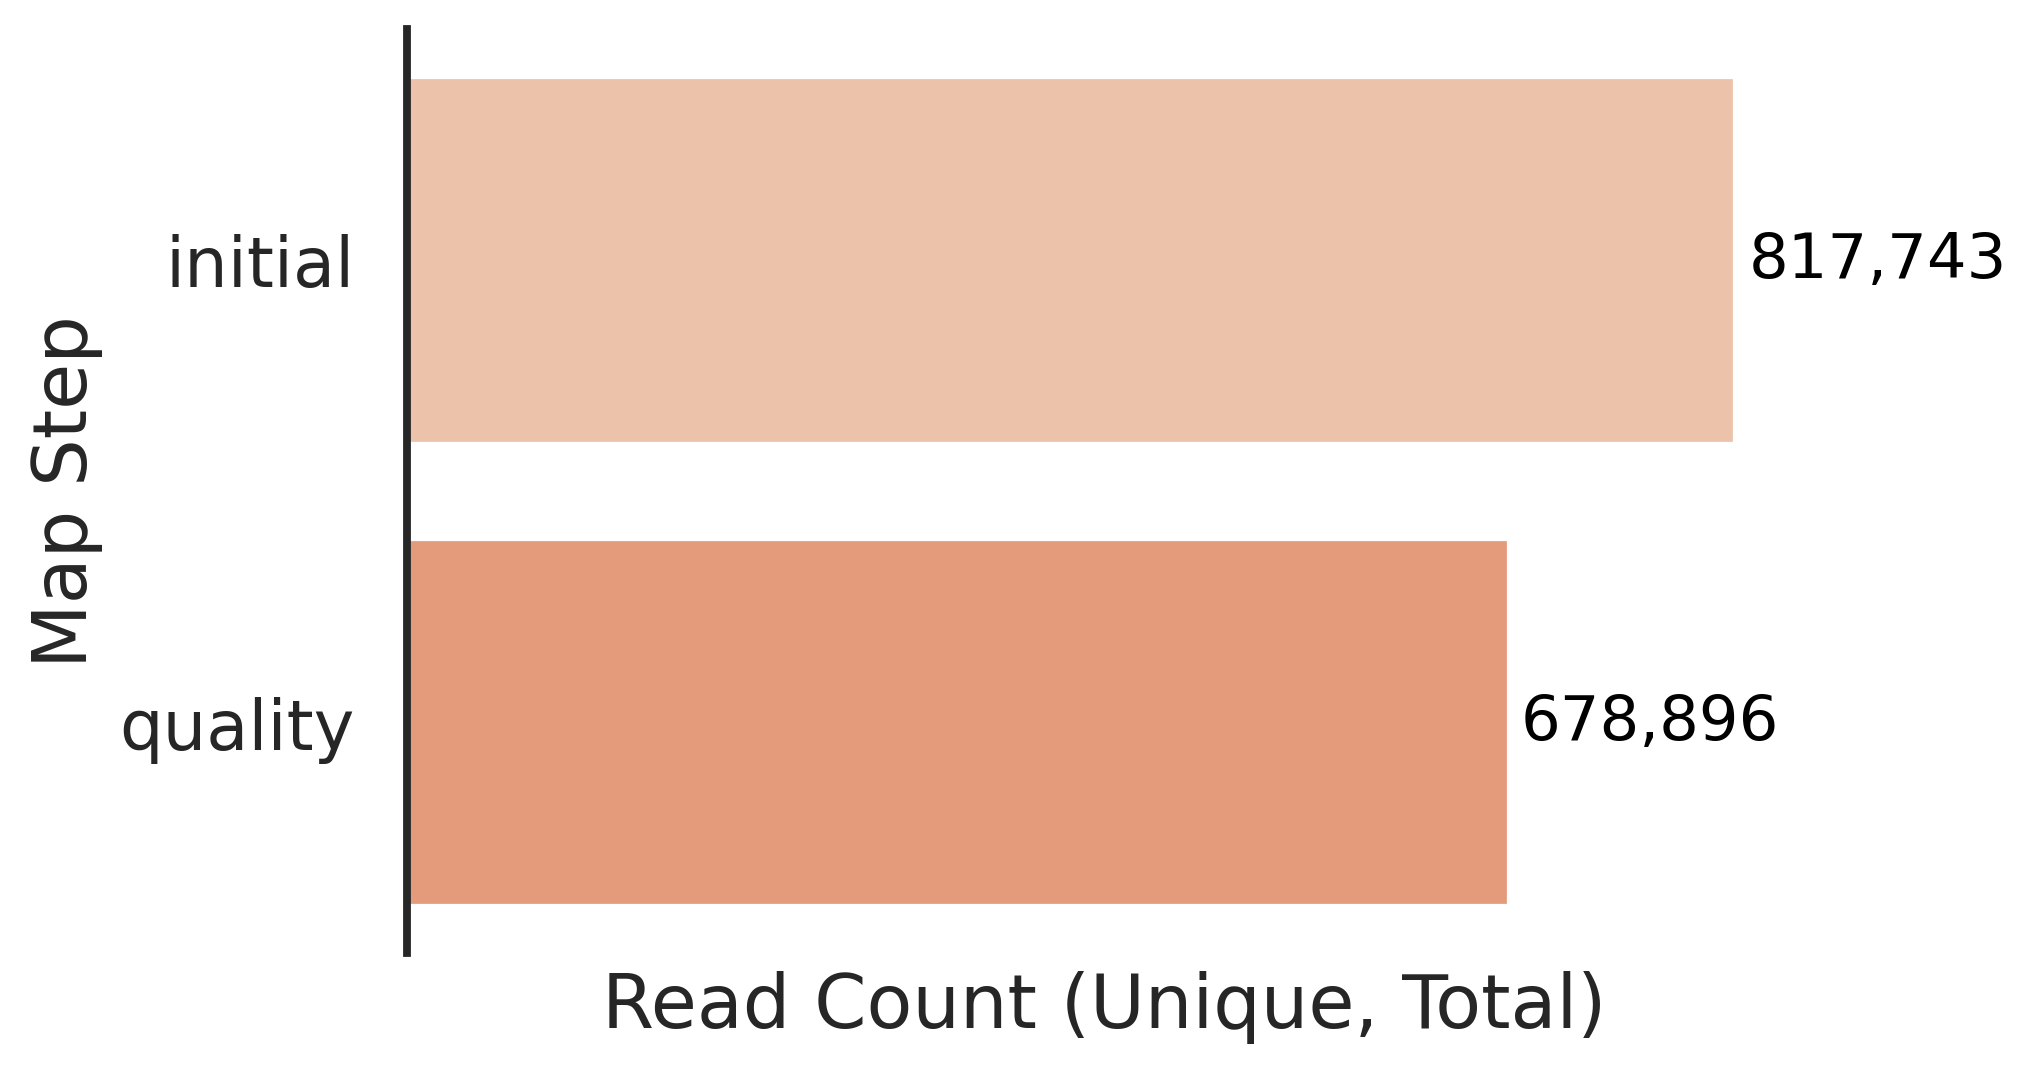

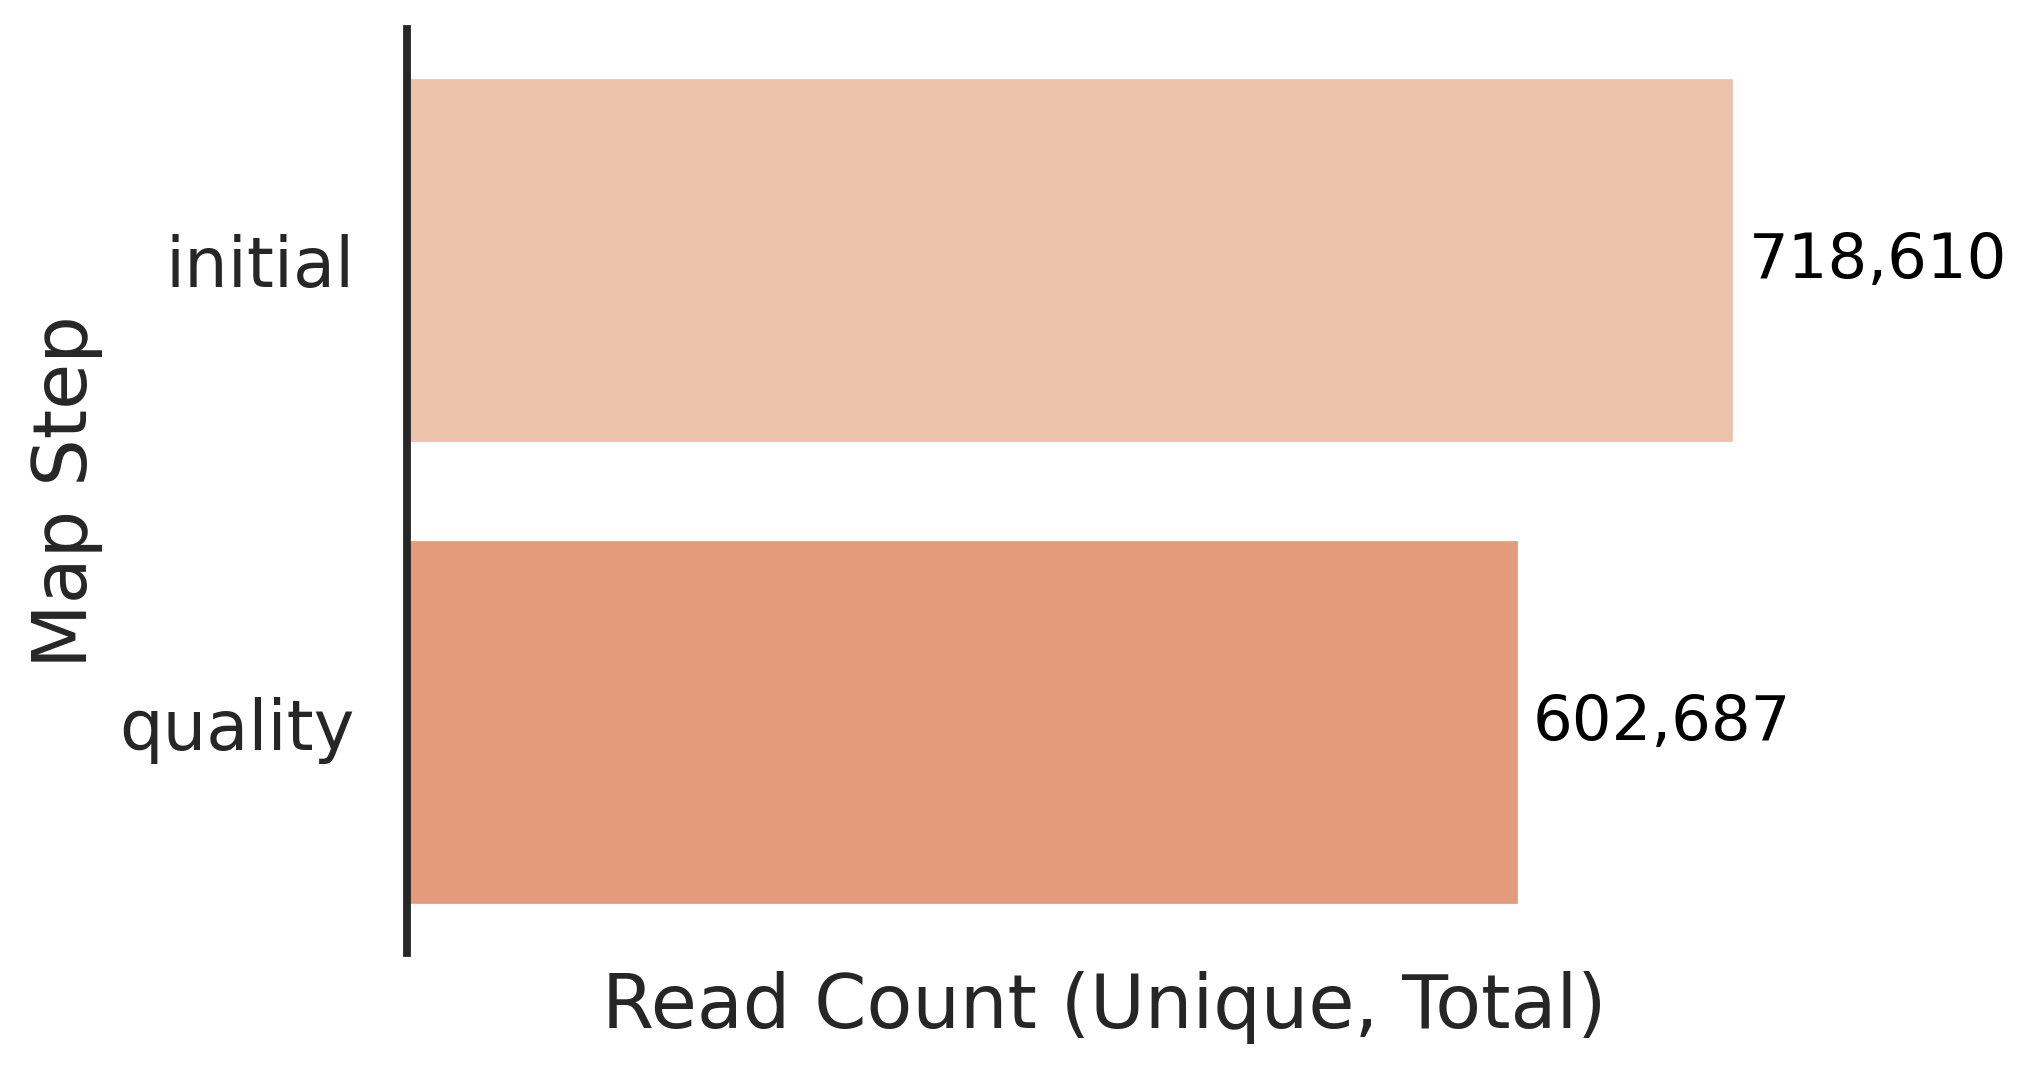

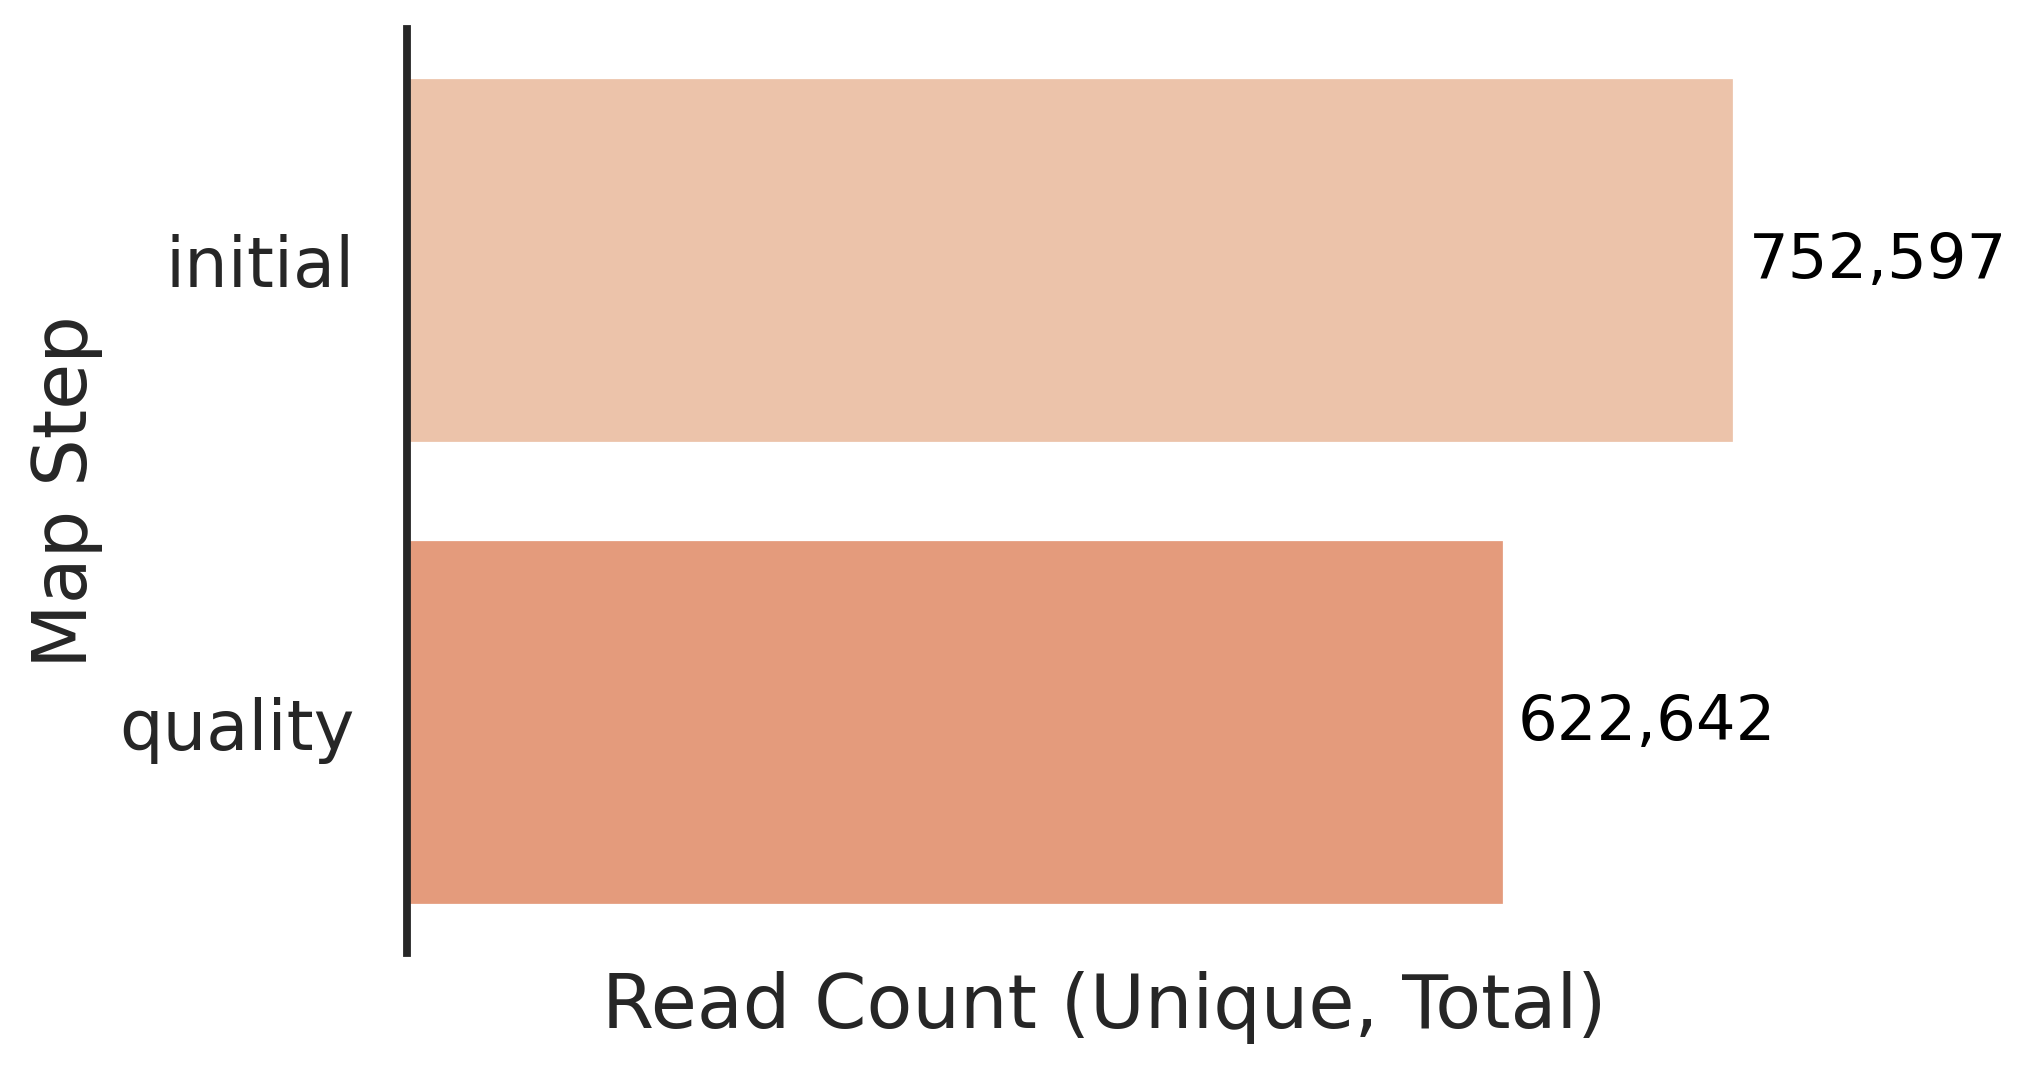

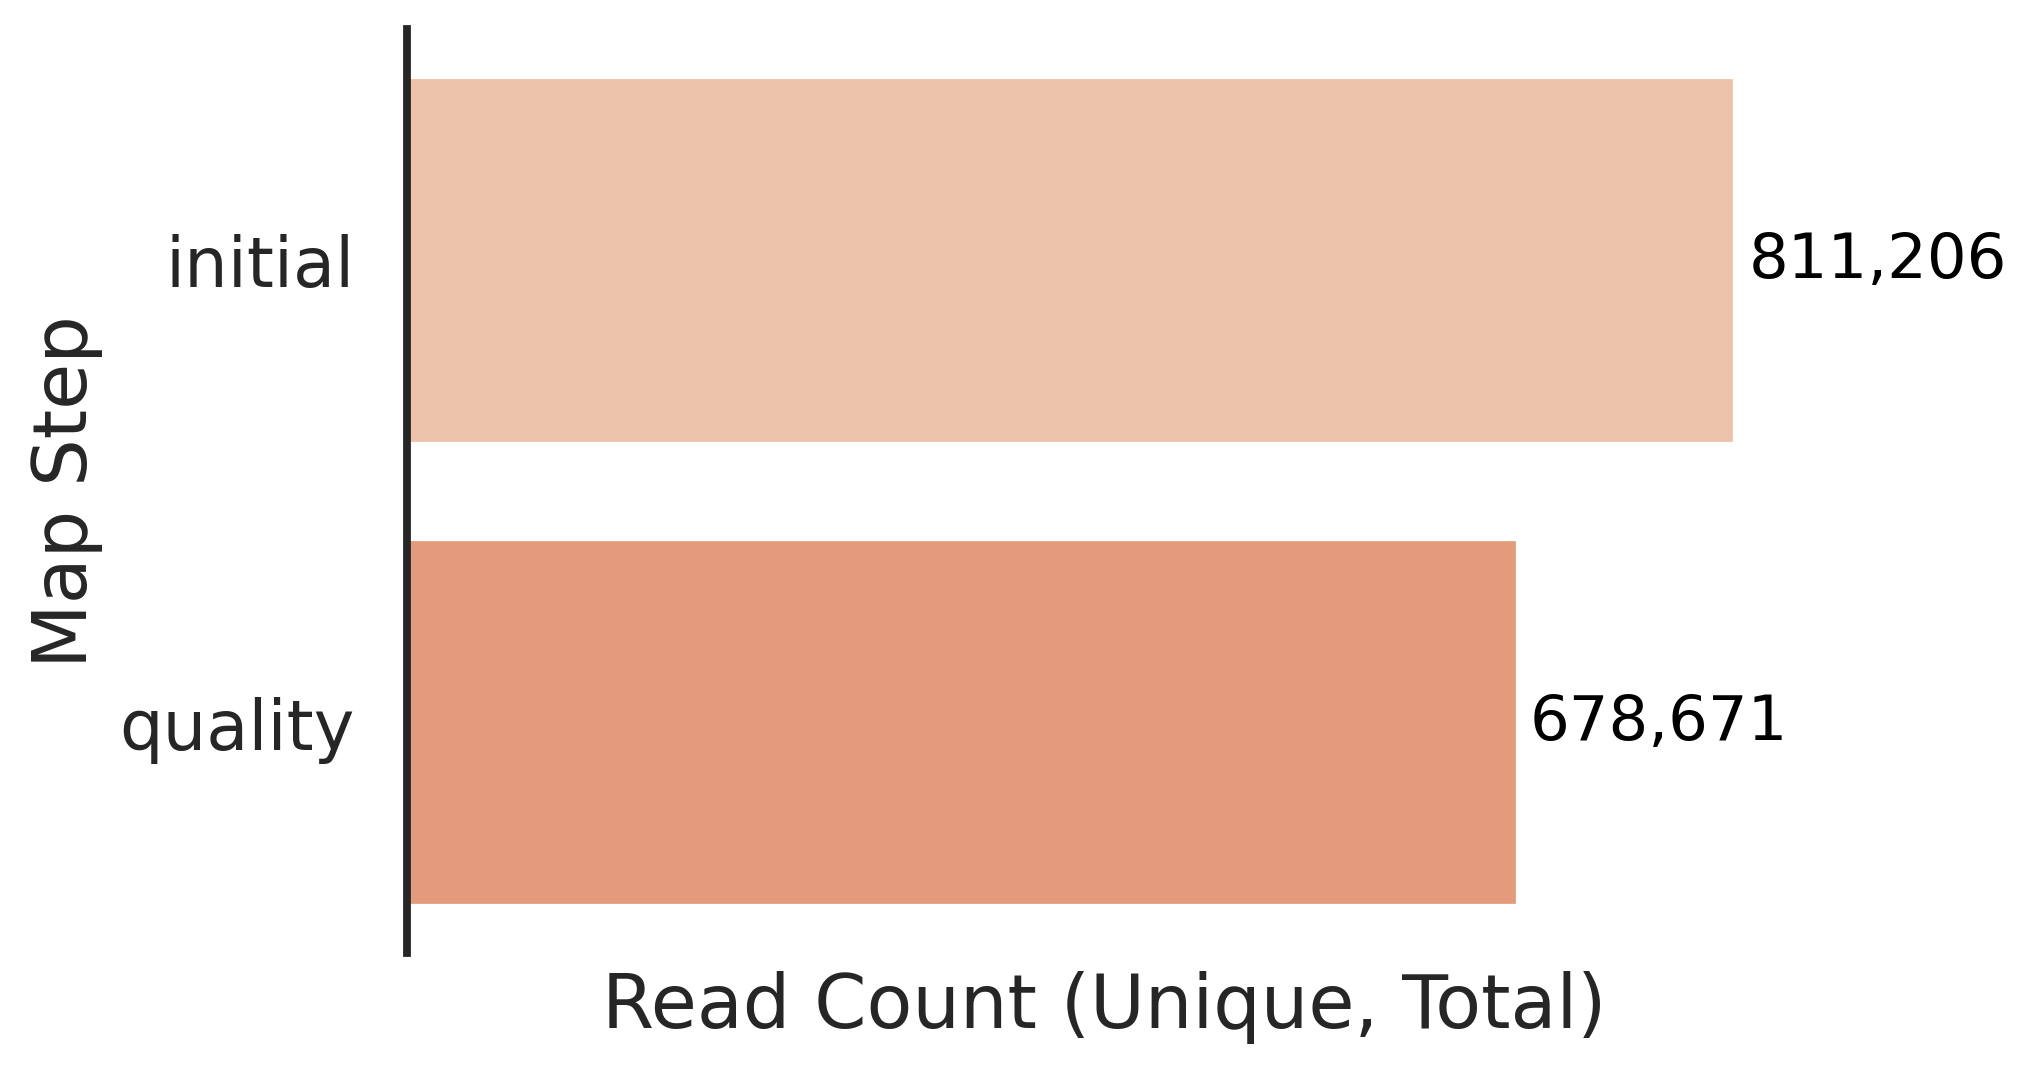

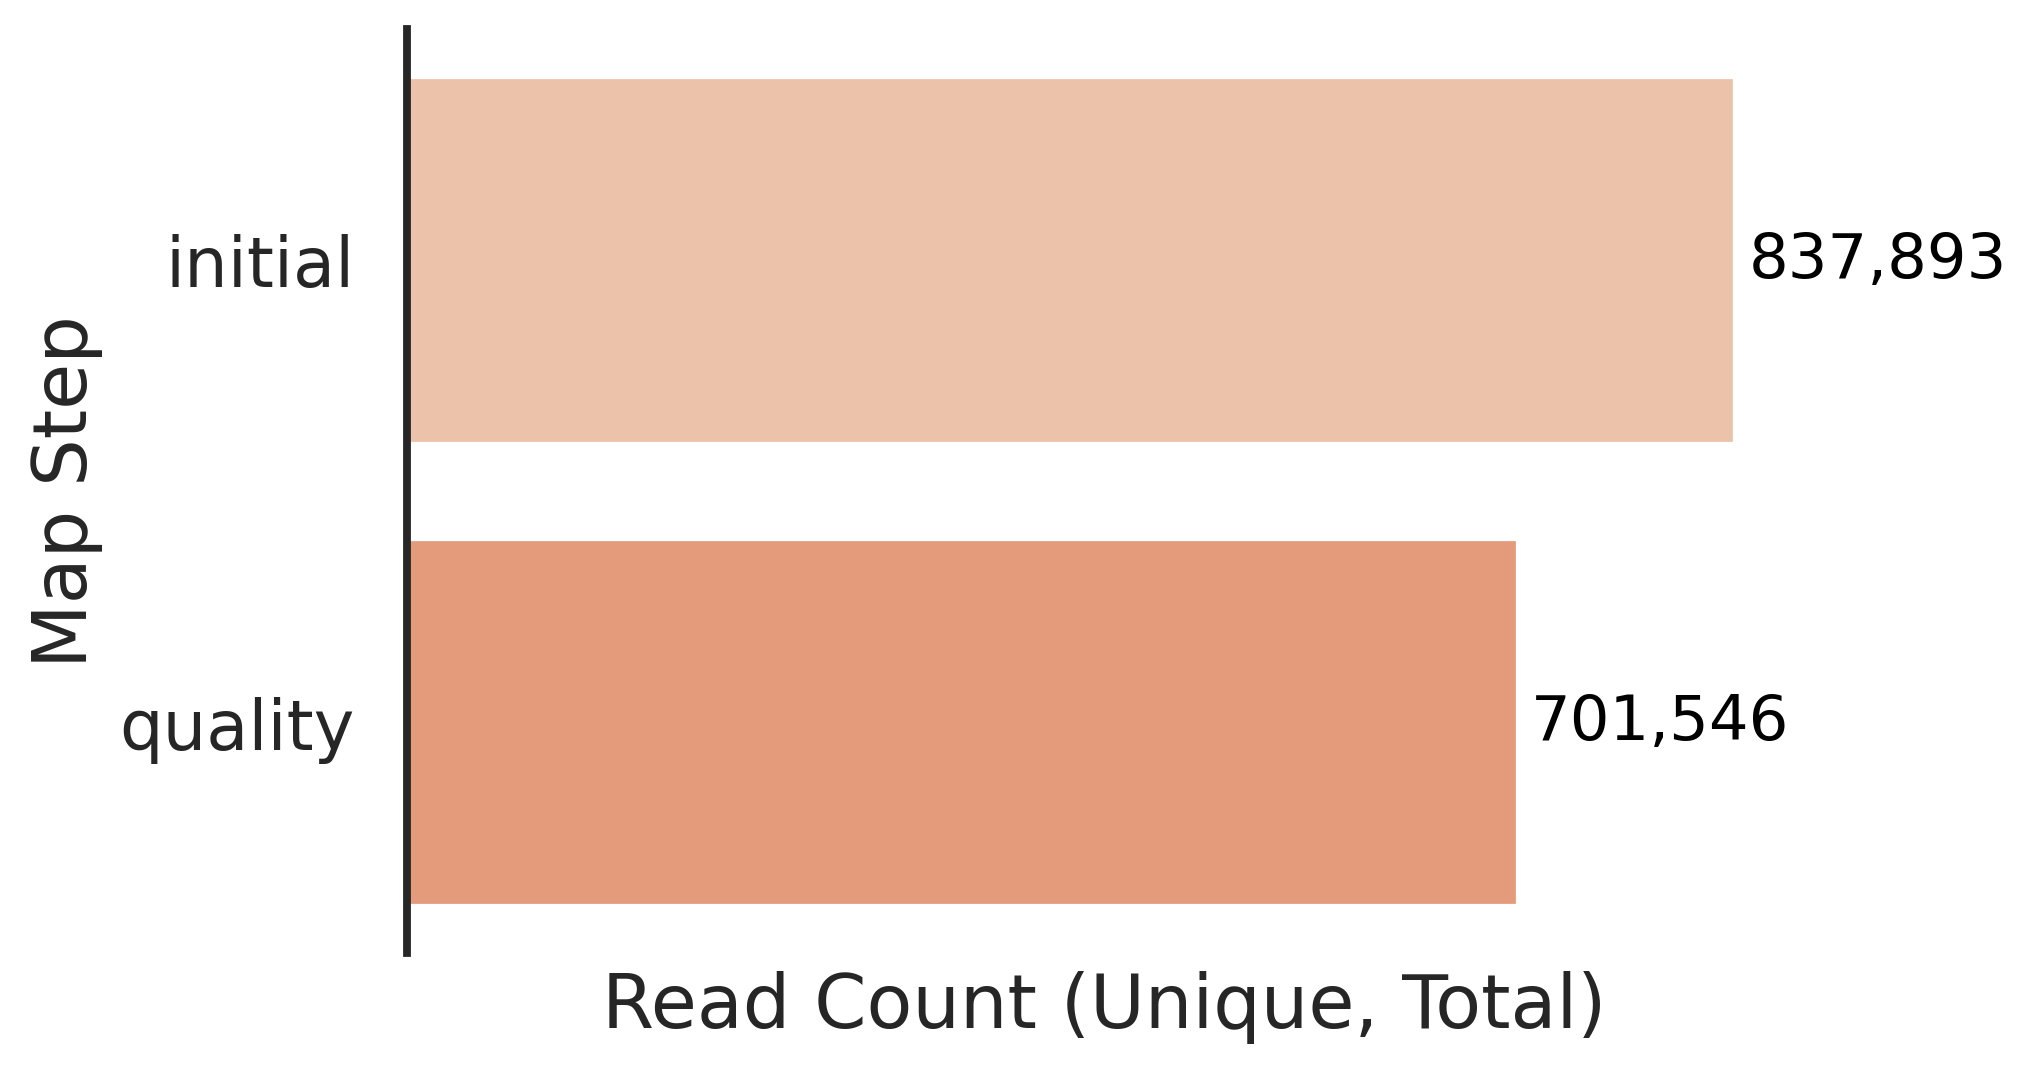

In [6]:
# Ran a few than interrupted

trebl_exp_results_no_err_corr = pipeline_no_err_corr.trebl_experiment_analysis(
        AD_seq_files = AD_seq_files,
        AD_bc_objects = [trebl_exp_ADBC2, trebl_exp_HawkBCs],
        RT_seq_files = RT_seq_files,
        RT_bc_objects = [trebl_exp_RTBC],
        reverse_complement = True,
        AD_umi_object = UMI,
        RT_umi_object = UMI
    )

In [7]:
simple_counts = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_simple_umi_counts.tsv", sep = "\t")
simple_counts["gene"] = simple_counts["ADBC2"] + simple_counts["HawkBCs"]
simple_counts

,ADBC2,HawkBCs,count,gene
0,GGTTAT,CACAACTTC,9681,GGTTATCACAACTTC
1,CCATAA,CACCGATTG,7836,CCATAACACCGATTG
2,ATGATC,CAATCTCTC,5743,ATGATCCAATCTCTC
3,TTAGGC,CAACAGTGC,5691,TTAGGCCAACAGTGC
4,ACATCA,CAACGCTTC,5390,ACATCACAACGCTTC
...,...,...,...,...
4679,AGTGCA,AAGAAGACG,1,AGTGCAAAGAAGACG
4680,AAACAC,CAATCTCTC,1,AAACACCAATCTCTC
4681,TGTTTT,CAAGAGATC,1,TGTTTTCAAGAGATC
4682,CCATAT,CATCCTGCC,1,CCATATCATCCTGCC


In [8]:
complex_counts = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2/pipeline_test/no_err_corr/trebl_experiment_a1_RNA_ADBC_S17/a1_RNA_ADBC_S17_directional_umi_counts.tsv", sep = "\t")
complex_counts

,gene,count
0,TTAGGCCAACAGTGC,5598
1,ACGAATACGACTGTG,234
2,CTAGAACAATGTGAC,2331
3,TAAACGCAGTGAAGC,681
4,TGATAACAGACAGCA,4002
...,...,...
4679,CCTACTATGCGCAAG,1
4680,AGTAAACAACCACTA,1
4681,AATTCAAGGAGTGTA,1
4682,GACTACAAGAACGAG,1


In [9]:
count_comparison = pd.merge(simple_counts[["gene", "count"]], complex_counts, on = 'gene', suffixes =("_simple", "_complex"))
count_comparison["diff"] = count_comparison["count_simple"] - count_comparison["count_complex"]
count_comparison[count_comparison["diff"] < 0]

,gene,count_simple,count_complex,diff


In [10]:
# Looks good for this one sample file!

In [ ]:
trebl_exp_results_no_err_corr_AD_results = trebl_exp_results_no_err_corr["AD_results"]
trebl_exp_results_no_err_corr_AD_results

In [ ]:
trebl_exp_results_no_err_corr_RT_results = trebl_exp_results_no_err_corr["RT_results"]
trebl_exp_results_no_err_corr_RT_results

# Checking a redone file

In [27]:
simple_counts = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2/TL4B2/rim/no_err_corr/trebl_experiment_a23_ADBC_Rim_Puro_R3_T0_S165/a23_ADBC_Rim_Puro_R3_T0_S165_simple_umi_counts.tsv", sep = "\t")
simple_counts["gene"] = simple_counts["ADBC2"] + simple_counts["HawkBCs"]
simple_counts

,ADBC2,HawkBCs,count,gene
0,CCATAA,CACCGATTG,122174,CCATAACACCGATTG
1,ATGATC,CAATCTCTC,56212,ATGATCCAATCTCTC
2,TTAGGC,CAACAGTGC,50339,TTAGGCCAACAGTGC
3,GCCTGT,CACAACTTC,47420,GCCTGTCACAACTTC
4,GAGTTT,CAACGCTTC,44210,GAGTTTCAACGCTTC
...,...,...,...,...
22586,CTACGG,ATAAGCGCC,1,CTACGGATAAGCGCC
22587,GGCCTT,ACGACCATA,1,GGCCTTACGACCATA
22588,GATAGG,CATGCCCAT,1,GATAGGCATGCCCAT
22589,CCATAA,AGTACATGC,1,CCATAAAGTACATGC


In [28]:
complex_counts = pd.read_csv("/global/scratch/projects/fc_mvslab/OpenProjects/Sanjana/TREBL/output/NKX2-2/TL4B2/rim/no_err_corr/trebl_experiment_a23_ADBC_Rim_Puro_R3_T0_S165/a23_ADBC_Rim_Puro_R3_T0_S165_directional_umi_counts.tsv", sep = "\t")
complex_counts

,gene,count
0,TGATAACAGACAGCA,20821
1,GATAAGCATTCCAAG,39015
2,ACGAATACGACTGTG,12129
3,CTAACCCAGTTACAC,4193
4,ACGTAGCAGGACTTG,10807
...,...,...
22561,CATTTCCACAACTTC,1
22562,GGAAGCCAGGTGGTT,1
22563,CAATATACACGCTGA,1
22564,TGCAAACAAGTATGG,1


In [29]:
count_comparison = pd.merge(simple_counts[["gene", "count"]], complex_counts, on = 'gene', suffixes =("_simple", "_complex"))
count_comparison["diff"] = count_comparison["count_simple"] - count_comparison["count_complex"]
count_comparison[count_comparison["diff"] < 0] # Yay!! the comparison looks good

,gene,count_simple,count_complex,diff


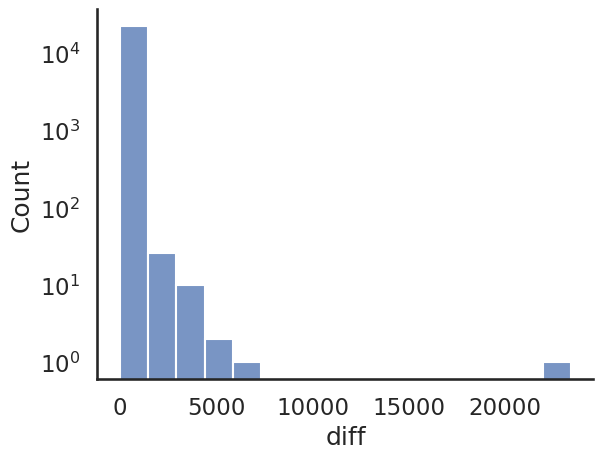

In [34]:
sns.histplot(data = count_comparison, x = 'diff', log_scale = (False, True))
sns.despine()